# Thousand

MLPClassifier

Игра на двадцать четыре карты и три игрока, на столе одновременно ноль, одна или две карты.
В игре получается $2 * 5^{25}$ состояний, но достижимых из стартового намного меньше (как во многих играх типа преферанса, hearts и так далее). В игре восемь ходов, но я поставил ограничение в двадцать, чтобы была возможность ошибаться (может надо больше?). В настоящей игре очки которые можно получить за игру -- от 0 до 120-200, я поставил наказание за неправильный ход равное -5 (может надо больше?).

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import thousand
from sklearn.neural_network import MLPClassifier

env = gym.make('Thousand-v1')

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

In [11]:
def generate_session_mlpc(agent: MLPClassifier):
    observations, actions = [], []
    total_reward = 0.

    observation, info = env.reset(options={'players': [thousand.Player(), thousand.Player()]})

    terminated = False
    truncated = False
    while not terminated and not truncated:
        probability = agent.predict_proba(observation.reshape(1, -1))[0]
        probability /= probability.sum()

        action = np.random.choice(n_actions, p=probability)
        # action = np.random.choice(n_actions, p=probability)

        new_observation, reward, terminated, truncated, info = env.step(action)

        observations.append(observation)
        actions.append(action)
        total_reward += reward

        observation = new_observation


    return np.array(observations), np.array(actions), total_reward


In [12]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile):
    reward_range = [min(rewards_batch), max(rewards_batch)]

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range, bins=20)
    plt.vlines([np.percentile(rewards_batch, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [13]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    n = len(states_batch)
    reward_threshold = np.percentile(rewards_batch, percentile)  #recalc threshold. hint : np.percentile

    elite_states = np.empty((0, *states_batch[0].shape[1:]), dtype=states_batch[0].dtype)
    elite_actions = np.empty((0, *actions_batch[0].shape[1:]), dtype=actions_batch[0].dtype)

    for i in range(n):
        if rewards_batch[i] >= reward_threshold:
            elite_states = np.concatenate((elite_states, states_batch[i]))
            elite_actions = np.concatenate((elite_actions, actions_batch[i]))

    return elite_states, elite_actions

In [14]:
def learn_thousand_with_chart_mlpc(n_sessions, percentile, n_games):
    agent = MLPClassifier(hidden_layer_sizes=(52, 52),
                          activation='tanh',
                          warm_start=True,  #keep progress between .fit(...) calls
                          max_iter=1  #make only 1 iteration on each .fit(...)
                          )

    agent.fit(np.zeros((1, 26), dtype=int), [[0] * 24])

    log = []

    for i in range(n_games):
        sessions = [generate_session_mlpc(agent) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch,
                                                    rewards_batch, percentile=percentile)

        reformated_elite_actions = np.zeros((elite_actions.size, 24), dtype=int)
        for i in range(elite_actions.size):
            reformated_elite_actions[i][elite_actions[i]] = 1
        agent.fit(elite_states, reformated_elite_actions)

        show_progress(rewards_batch, log, percentile)

In [15]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [16]:
def generate_session_random():
    observations, actions = [], []
    total_reward = 0.

    observation, info = env.reset(options={'players': [thousand.Player(), thousand.Player()]})

    terminated = False
    truncated = False
    while not terminated and not truncated:
        probability = np.full((24,), 1 / 24)

        action = np.random.choice(n_actions, p=probability)

        new_observation, reward, terminated, truncated, info = env.step(action)

        observations.append(observation)
        actions.append(action)
        total_reward += reward

        observation = new_observation


    return np.array(observations), np.array(actions), total_reward

In [17]:
def learn_thousand_with_chart_random(n_sessions, percentile, n_games):
    log = []

    for i in range(n_games):
        sessions = [generate_session_random() for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        show_progress(rewards_batch, log, percentile)

# Рандом

mean reward = -71.730, threshold=-62.700


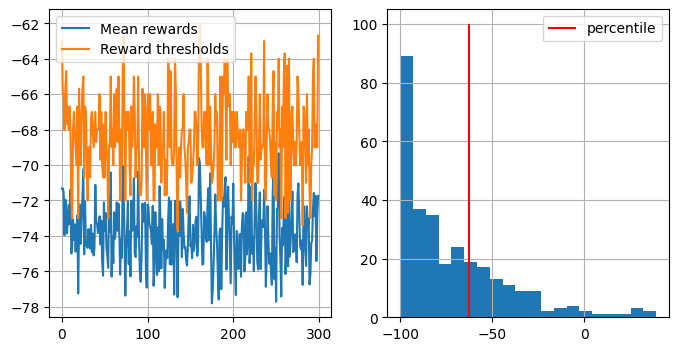

In [11]:
learn_thousand_with_chart_random(300, 70, 300)

# MLPC

Он не может научиться делать корректные ходы

mean reward = -471.513, threshold=-324.700


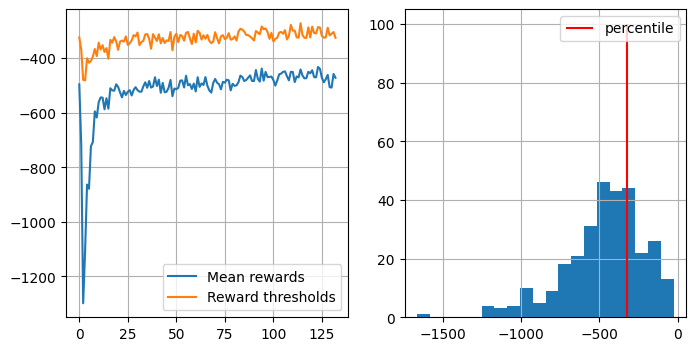

KeyboardInterrupt: 

In [18]:
learn_thousand_with_chart_mlpc(300, 70, 300)